In [ ]:
%%writefile /kaggle/working/r4.2/optimized_feature_extraction.py

#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Optimized Feature Extraction v3.5 (Fix: Ambiguous Truth Value in Email Logic)
"""
import os, sys, time
import pandas as pd
import numpy as np
from datetime import datetime
import shutil
from joblib import Parallel, delayed
import glob

# --- CẤU HÌNH ---
DNAME = 'r4.2'
NUM_WEEK = 73 
CHUNK_SIZE = 5000000 

# MASTER SCHEMA (Để chuẩn hóa cột CSV)
ALL_COLS = [
    'id', 'date', 'user', 'pc', 'activity', 'type', 
    'to', 'cc', 'bcc', 'from', 'size', '#att', 'content', 
    'url/fname'
]

# ==========================================
# 1. HELPER & VECTORIZED LOGIC
# ==========================================
def extract_row_features_vectorized(df, users_df):
    # 1. TIME
    df['hour'] = df['dt'].dt.hour
    df['weekday'] = df['dt'].dt.weekday
    is_weekend = df['weekday'] >= 5
    is_after = (df['hour'] < 8) | (df['hour'] > 17)
    conditions = [ (is_weekend & is_after), is_weekend, is_after ]
    choices = [4, 3, 2]
    df['time'] = np.select(conditions, choices, default=1)
    
    # 2. PC CHECK
    df = df.merge(users_df[['pc']], left_on='user', right_index=True, how='left')
    df['pc_type'] = np.where(df['pc_x'] == df['pc_y'], 0, 2)
    df.drop(columns=['pc_y'], inplace=True)
    df.rename(columns={'pc_x': 'pc'}, inplace=True)

    # 3. FEATURES
    feature_cols = [f'f{i}' for i in range(20)]
    for c in feature_cols: df[c] = 0
    
    # FILE
    is_file = df['type'] == 'file'
    if is_file.any():
        fname_vals = df.loc[is_file, 'url/fname'].astype(str).fillna('').values
        content_vals = df.loc[is_file, 'content'].astype(str).fillna('').values
        
        ftype = np.ones(len(fname_vals))
        fname_s = pd.Series(fname_vals)
        ftype[fname_s.str.contains(r'\.zip|\.rar|\.7z', regex=True)] = 2
        ftype[fname_s.str.contains(r'\.jpg|\.png|\.bmp', regex=True)] = 3
        ftype[fname_s.str.contains(r'\.doc|\.pdf', regex=True)] = 4
        ftype[fname_s.str.contains(r'\.txt|\.cfg', regex=True)] = 5
        ftype[fname_s.str.contains(r'\.exe|\.sh', regex=True)] = 6
        
        df.loc[is_file, 'f1'] = ftype
        df.loc[is_file, 'f2'] = [len(s) for s in content_vals]
        df.loc[is_file, 'f3'] = [s.count(' ')+1 for s in content_vals]
        df.loc[is_file, 'f4'] = np.where(pd.Series(fname_vals).str.startswith('C'), 1, 
                                np.where(pd.Series(fname_vals).str.startswith('R'), 2, 0))
        df.loc[is_file, 'f5'] = [s.count('\\') for s in fname_vals]

    # HTTP
    is_http = df['type'] == 'http'
    if is_http.any():
        url_vals = df.loc[is_http, 'url/fname'].astype(str).fillna('').values
        content_vals = df.loc[is_http, 'content'].astype(str).fillna('').values
        
        htype = np.ones(len(url_vals))
        url_s = pd.Series(url_vals)
        htype[url_s.str.contains('facebook|twitter|instagram', case=False)] = 2
        htype[url_s.str.contains('dropbox|drive.google', case=False)] = 3
        htype[url_s.str.contains('job|indeed|recruit', case=False)] = 4
        htype[url_s.str.contains('wikileaks|hack', case=False)] = 5
        
        df.loc[is_http, 'f6'] = htype
        df.loc[is_http, 'f7'] = [len(s) for s in url_vals]
        df.loc[is_http, 'f8'] = [s.count('/')-2 for s in url_vals]
        df.loc[is_http, 'f9'] = [len(s) for s in content_vals]
        df.loc[is_http, 'f10'] = [s.count(' ')+1 for s in content_vals]

    # EMAIL
    is_email = df['type'] == 'email'
    if is_email.any():
        to_vals = df.loc[is_email, 'to'].astype(str).fillna('').values
        bcc_vals = df.loc[is_email, 'bcc'].astype(str).fillna('').values
        content_vals = df.loc[is_email, 'content'].astype(str).fillna('').values
        
        n_to = [s.count(';')+1 if s else 0 for s in to_vals]
        n_bcc = [s.count(';')+1 if s else 0 for s in bcc_vals]
        
        df.loc[is_email, 'f11'] = np.array(n_to) + np.array(n_bcc)
        df.loc[is_email, 'f12'] = df.loc[is_email, '#att'].fillna(0)
        
        to_s = pd.Series(to_vals)
        bcc_s = pd.Series(bcc_vals)
        
        # --- FIX LỖI TẠI ĐÂY: Thay 'or' bằng '|' và đóng ngoặc ---
        # Logic: (To nội bộ) VÀ (Bcc rỗng HOẶC Bcc nội bộ) -> Internal (0)
        # Ngược lại -> External (1)
        # Lưu ý: 'dtaa.com' là domain công ty trong dataset CERT
        
        is_internal_to = to_s.str.contains('dtaa.com', regex=False)
        is_internal_bcc = (bcc_s == '') | bcc_s.str.contains('dtaa.com', regex=False)
        
        # Nếu cả To và Bcc đều an toàn -> 0, ngược lại -> 1
        xemail = np.where(is_internal_to & is_internal_bcc, 0, 1)
        
        df.loc[is_email, 'f13'] = xemail
        df.loc[is_email, 'f17'] = df.loc[is_email, 'size'].fillna(0)
        df.loc[is_email, 'f18'] = [len(s) for s in content_vals]
        df.loc[is_email, 'f19'] = [s.count(' ')+1 for s in content_vals]

    # Act Code
    conditions = [
        df['type'] == 'logon', df['type'] == 'device', 
        df['type'] == 'http', df['type'] == 'email', df['type'] == 'file'
    ]
    choices = [1, 3, 5, 6, 7]
    df['act_code'] = np.select(conditions, choices, default=0)
    
    df.loc[(df['type']=='logon') & (df['activity']!='Logon'), 'act_code'] = 2
    df.loc[(df['type']=='device') & (df['activity']!='Connect'), 'act_code'] = 4
    
    return df

# ==========================================
# 2. STEP 1: FAST SPLIT (Standardized)
# ==========================================
def fast_split_by_week():
    # Kiểm tra số lượng file CSV
    if os.path.exists("DataByWeek") and len(glob.glob("DataByWeek/*.csv")) > 60:
        print("⚡ Step 1 (Split) đã có dữ liệu hợp lệ. Bỏ qua.")
        return

    print("🚀 Step 1: Tách dữ liệu (Vectorized + Standardized)...")
    if os.path.exists("DataByWeek"): shutil.rmtree("DataByWeek")
    os.makedirs("DataByWeek")

    START_DATE = datetime.strptime('2010-01-02', '%Y-%m-%d')
    files = ['device.csv', 'email.csv', 'file.csv', 'http.csv', 'logon.csv']
    
    for fname in files:
        if not os.path.exists(fname): continue
        print(f"  -> Xử lý {fname}...")
        act_type = fname.split('.')[0]
        
        for chunk in pd.read_csv(fname, chunksize=CHUNK_SIZE, on_bad_lines='skip', engine='python'):
            chunk['dt'] = pd.to_datetime(chunk['date'], format="%m/%d/%Y %H:%M:%S")
            chunk['week_num'] = (chunk['dt'] - START_DATE).dt.days // 7
            chunk['type'] = act_type
            
            # CHUẨN HÓA CỘT
            chunk = chunk.reindex(columns=ALL_COLS + ['week_num', 'dt'])
            
            for w, group in chunk.groupby('week_num'):
                if w < 0 or w >= NUM_WEEK: continue
                save_path = f"DataByWeek/{int(w)}.csv"
                header = not os.path.exists(save_path)
                group.drop(columns=['week_num', 'dt']).to_csv(save_path, mode='a', index=False, header=header)

# ==========================================
# 3. STEP 2: USER & LABEL
# ==========================================
def get_mal_userdata():
    possible_paths = ["/kaggle/input/cert42-answer/answers"]
    found = False
    for p in possible_paths:
        if os.path.exists(os.path.join(p, "insiders.csv")):
            if not os.path.exists("answers"):
                try: os.symlink(p, "answers")
                except: shutil.copytree(p, "answers")
            found = True
            break
            
    print("  -> Đang đọc LDAP...")
    allfiles = glob.glob('LDAP/*.csv')
    alluser = {}
    for file in sorted(allfiles):
        month = os.path.basename(file).split('.')[0]
        df_ldap = pd.read_csv(file)
        for _, row in df_ldap.iterrows():
            if row['user_id'] not in alluser:
                alluser[row['user_id']] = row.drop('user_id').tolist() + [month, np.nan]

    if os.path.isfile("psychometric.csv"):
        p_score = pd.read_csv("psychometric.csv")
        for _, row in p_score.iterrows():
            if row['user_id'] in alluser: 
                alluser[row['user_id']] += row.iloc[2:].tolist()

    cols = ['uname', 'email', 'role', 'b_unit', 'f_unit', 'dept', 'team', 'sup', 'wstart', 'wend', 'O', 'C', 'E', 'A', 'N']
    df = pd.DataFrame.from_dict(alluser, orient='index', columns=cols)
    
    if os.path.exists("DataByWeek/1.csv"):
        try:
            w1 = pd.read_csv("DataByWeek/1.csv", usecols=['user','pc'])
            user_pcs = w1.groupby('user')['pc'].apply(lambda x: list(set(x))).to_dict()
        except: user_pcs = {}
    else: user_pcs = {}
    df['pc'] = df.index.map(lambda x: user_pcs.get(x, [None])[0])

    print("  -> Nạp danh sách hành vi Insider...")
    malicious_ids_set = set()
    if os.path.exists("answers/insiders.csv"):
        insiders = pd.read_csv("answers/insiders.csv")
        insiders = insiders[insiders['dataset'].astype(str) == '4.2']
        for _, row in insiders.iterrows():
            path1 = f"answers/{row['details']}"
            path2 = f"answers/r4.2-{row['scenario']}/{os.path.basename(row['details'])}"
            final = path1 if os.path.exists(path1) else (path2 if os.path.exists(path2) else None)
            if final:
                try:
                    mal_log = pd.read_csv(final, header=None, engine='python', on_bad_lines='skip')
                    if mal_log.shape[1] > 1: malicious_ids_set.update(mal_log[1].values)
                except: pass
    
    print(f"     => {len(malicious_ids_set)} hành vi độc hại.")
    return df, malicious_ids_set

# ==========================================
# 4. STEP 3: PIPELINE (PARQUET)
# ==========================================
def process_week_vectorized(week, users_df, mal_ids_set):
    csv_path = f"DataByWeek/{week}.csv"
    if not os.path.exists(csv_path): return
    try: df = pd.read_csv(csv_path, low_memory=False)
    except: return
    if df.empty: return
    
    df['dt'] = pd.to_datetime(df['date'], format="%m/%d/%Y %H:%M:%S")
    df.sort_values('dt', inplace=True)
    
    # Extract Features
    df = extract_row_features_vectorized(df, users_df)
    
    # Label
    df['mal_act'] = df['id'].isin(mal_ids_set).astype(int)
    
    week_res = []
    
    for u, u_group in df.groupby('user'):
        if u not in users_df.index: continue
        
        u_static = users_df.loc[u, ['O','C','E','A','N','role','dept']].tolist()
        dyn_feats = [1 if (u_group['time'] >= 3).any() else 0] 
        
        act_col_map = {
            3: ['f0'], 7: ['f1','f2','f3','f4','f5'],
            6: ['f11','f12','f17','f19'], 5: ['f7','f8','f10']
        }
        
        for act_code in [1, 3, 5, 6, 7]:
            cols_to_stat = act_col_map.get(act_code, [])
            act_rows = u_group[u_group['act_code'] == act_code]
            
            for tm in ['all', 1, 2, 3]:
                if tm == 'all': curr = act_rows
                elif tm == 3: curr = act_rows[act_rows['time'] >= 3]
                else: curr = act_rows[act_rows['time'] == tm]
                
                stats = [len(curr)]
                for c in cols_to_stat:
                    if len(curr) > 0:
                        vals = pd.to_numeric(curr[c], errors='coerce').values
                        stats.extend([np.nanmean(vals), np.nanstd(vals), np.nanmin(vals), np.nanmax(vals)])
                    else: stats.extend([0,0,0,0])
                dyn_feats.extend(stats)

        is_insider = 1 if u_group['mal_act'].sum() > 0 else 0
        week_res.append([week, u] + u_static + dyn_feats + [is_insider])

    if week_res:
        out_dir = 'ExtractedData/week_parquet'
        os.makedirs(out_dir, exist_ok=True)
        res_df = pd.DataFrame(week_res)
        res_df.columns = res_df.columns.astype(str)
        res_df.to_parquet(f"{out_dir}/part_{week}.parquet", index=False)

if __name__ == "__main__":
    st = time.time()
    
    fast_split_by_week()
    print(f"✅ Step 1 Done. Time: {(time.time()-st)/60:.2f} m")
    
    users, mal_ids = get_mal_userdata()
    print(f"✅ Step 2 Done. Time: {(time.time()-st)/60:.2f} m")
    
    print("🚀 Step 3: Tính toán & Xuất Parquet...")
    Parallel(n_jobs=4)(delayed(process_week_vectorized)(i, users, mal_ids) for i in range(NUM_WEEK))
    print(f"🎉 ALL DONE. Total Time: {(time.time()-st)/60:.2f} m")

    # Kiểm tra lần cuối
    pq_files = glob.glob("ExtractedData/week_parquet/*.parquet")
    if len(pq_files) > 0:
        print(f"-> THÀNH CÔNG: Tìm thấy {len(pq_files)} file parquet.")
    else:
        print("-> CẢNH BÁO: Vẫn không thấy file parquet. Kiểm tra lại Logs.")

In [ ]:
# Xóa thư mục cũ chứa file lỗi
!rm -rf /kaggle/working/act_type_map.json
!rm -rf /kaggle/working/dept_map.json
!rm -rf /kaggle/working/role_map.json
!rm -rf /kaggle/working/role_map.json
!rm -rf /kaggle/working/team_map.json
!rm -rf /kaggle/working/tmp_device
!rm -rf /kaggle/working/tmp_email
!rm -rf /kaggle/working/tmp_file
!rm -rf /kaggle/working/tmp_http
!rm -rf /kaggle/working/tmp_logon

print("Đã dọn dẹp file lỗi. Bây giờ bạn hãy chạy lại script chính nhé!")

In [ ]:
# ================= CERT r4.2 ACTION-LEVEL MULTICLASS UEBA PIPELINE =================
# One-cell | Kaggle-ready | Deep Learning + Explainable

import os, shutil, time, json
import pandas as pd
import numpy as np
from joblib import Parallel, delayed

# ================= CONFIG =================
SOURCE_DIR = '/kaggle/input/cert-r4-2/archive'
ANSWERS_DIR = '/kaggle/input/cert42-answer/answers'
OUTPUT_DIR = '/kaggle/working'
CHUNK_SIZE = 2_000_000
NUM_CORES = 4

ACT_MAP = {'logon':1, 'device':2, 'file':3, 'email':4, 'http':5}
#ORG_DOMAIN = 'dtaa.com'
#EXEC_EXT = ('.exe','.zip','.tar')
#SENSITIVE_PREFIX = 'R'
#RISKY_HTTP = ['job','hack','leak','upload','drive','dropbox','keylog']

# ================= 1. USER CONTEXT =================
def load_user_context():
    ldap_dir = os.path.join(SOURCE_DIR,'LDAP')
    if not os.path.exists(ldap_dir): ldap_dir = SOURCE_DIR

    users={}
    for f in os.listdir(ldap_dir):
        if f.endswith('.csv'):
            df=pd.read_csv(os.path.join(ldap_dir,f))
            for _,r in df.iterrows():
                users[r['user_id']] = r.to_dict()

    df_users=pd.DataFrame.from_dict(users,orient='index')

    psy=os.path.join(SOURCE_DIR,'psychometric.csv')
    if os.path.exists(psy):
        df_users=df_users.merge(pd.read_csv(psy),on='user_id',how='left')
    else:
        for c in ['O','C','E','A','N']: df_users[c]=0.5

    def enc(col): return {v:i+1 for i,v in enumerate(sorted(col.fillna('UNK').unique()))}

    role_map,dept_map,team_map=enc(df_users['role']),enc(df_users['department']),enc(df_users['team'])

    for m,n in [(role_map,'role'),(dept_map,'dept'),(team_map,'team')]:
        with open(f'{OUTPUT_DIR}/{n}_map.json','w') as f:
            json.dump({str(v):k for k,v in m.items()},f,indent=2)

    with open(f'{OUTPUT_DIR}/act_type_map.json','w') as f:
        json.dump({str(v):k for k,v in ACT_MAP.items()},f,indent=2)

    ctx={}
    for _,r in df_users.iterrows():
        ctx[r['user_id']]=[
            role_map.get(r['role'],0),
            dept_map.get(r['department'],0),
            team_map.get(r['team'],0),
            float(r['O']),float(r['C']),float(r['E']),float(r['A']),float(r['N'])
        ]
    return ctx

# ================= 2. LOAD MALICIOUS IDS =================
def load_malicious_ids():
    df=pd.read_csv(os.path.join(ANSWERS_DIR,'insiders.csv'))
    df=df[df['dataset'].astype(str)=='4.2']
    ids=set()
    for _,r in df.iterrows():
        f=os.path.join(ANSWERS_DIR,f"r4.2-{r['scenario']}",r['details'])
        if os.path.exists(f):
            with open(f) as fh:
                for l in fh:
                    ids.add(l.strip().split(',')[1].replace('{','').replace('}',''))
    return mal_ids

# ================= 3. FEATURE ENGINEERING =================
# def add_time_features(df):
#     df['dt']=pd.to_datetime(df['date'],errors='coerce')
#     df=df.dropna(subset=['dt'])
#     df['ts']=(df['dt'].astype('int64')//10**9).astype(np.int64)
#     df['hour']=df['dt'].dt.hour.astype(np.int8)
#     df['dow']=df['dt'].dt.dayofweek.astype(np.int8)
#     df['is_weekend']=(df['dow']>=5).astype(np.int8)
#     df['is_after_hours']=((df['hour']<8)|(df['hour']>18)).astype(np.int8)
#     df['is_night']=((df['hour']<7)|(df['hour']>22)).astype(np.int8)
#     return df

# def add_user_context(df,ctx):
#     cols=['role_id','dept_id','team_id','psy_O','psy_C','psy_E','psy_A','psy_N']
#     return pd.concat([df,pd.DataFrame(df['user'].map(lambda u:ctx.get(u,[0]*8)).tolist(),columns=cols)],axis=1)

# ================= 4. CHUNK PROCESS =================
# ================= 4. CHUNK PROCESS (UPDATED) =================
def process_chunk(chunk, act, ctx, mal_ids):
    # ================= 1. BASE CLEANING =================
    chunk['id'] = chunk['id'].astype(str).str.replace('{','').str.replace('}','')
    chunk['dt'] = pd.to_datetime(chunk['date'], errors='coerce')
    chunk = chunk.dropna(subset=['dt'])

    # ================= 2. TIME FEATURES =================
    chunk['ts'] = (chunk['dt'].astype('int64') // 10**9).astype(np.int64)
    chunk['hour'] = chunk['dt'].dt.hour.astype(np.int8)
    chunk['dow'] = chunk['dt'].dt.dayofweek.astype(np.int8)
    chunk['is_weekend'] = (chunk['dow'] >= 5).astype(np.int8)
    # UEBA Standard: Night (22h-7h), After Hours (18h-8h)
    chunk['is_after_hours'] = ((chunk['hour'] < 8) | (chunk['hour'] > 18)).astype(np.int8)
    chunk['is_night']       = ((chunk['hour'] < 7) | (chunk['hour'] > 22)).astype(np.int8)
    
    # ================= 3. USER CONTEXT =================
    ctx_cols = ['role_id','dept_id','team_id','psy_O','psy_C','psy_E','psy_A','psy_N']
    u_vals = [ctx.get(u, [0]*8) for u in chunk['user']]
    chunk_ctx = pd.DataFrame(u_vals, columns=ctx_cols, index=chunk.index)
    chunk = pd.concat([chunk, chunk_ctx], axis=1)

    # ================= 4. MULTICLASS LABEL =================
    # 0: benign | 1: logon | 2: device | 3: file | 4: email | 5: http
    act_type_code = ACT_MAP[act]
    chunk['label'] = np.where(chunk['id'].isin(mal_ids), act_type_code, 0).astype(np.int8)
    chunk['activity_type'] = act_type_code # Feature cho model biết loại log

    # ================= 5. FEATURE ENGINEERING (LOGIC MỚI) =================
    # Khởi tạo tất cả cột đặc trưng bằng 0
    # Đặt tên cột rõ nghĩa thay vì f1, f2...
    features = [
        # File features
        'file_category', 'file_content_len', 'file_content_words', 
        'file_drive_type', 'file_depth',
        # HTTP features
        'http_category', 'http_url_len', 'http_url_depth', 
        'http_content_len', 'http_content_words',
        # Email features
        'email_recipients_count', 'email_attachment_count', 'email_is_external',
        'email_size', 'email_content_len', 'email_content_words',
        # Session features
        'is_session_start'
    ]
    
    for f in features:
        chunk[f] = 0.0 # Dùng float để tránh lỗi tính toán, sau này model tự xử lý

    # ---------------------------------------------------------
    # A. XỬ LÝ FILE (Logic mapping từ f1 -> f5)
    # ---------------------------------------------------------
    if act == 'file':
        fname = chunk['filename'].fillna('').astype(str)
        content = chunk['content'].fillna('').astype(str)
        fname_lower = fname.str.lower()

        # F1: File Category (1:Other, 2:Archive, 3:Image, 4:Doc, 5:Text, 6:Exe)
        # Mặc định là 1
        chunk['file_category'] = 1 
        chunk.loc[fname_lower.str.contains(r'\.zip|\.rar|\.7z', regex=True), 'file_category'] = 2
        chunk.loc[fname_lower.str.contains(r'\.jpg|\.png|\.bmp', regex=True), 'file_category'] = 3
        chunk.loc[fname_lower.str.contains(r'\.doc|\.pdf|\.xls|\.ppt', regex=True), 'file_category'] = 4
        chunk.loc[fname_lower.str.contains(r'\.txt|\.cfg|\.csv', regex=True), 'file_category'] = 5
        chunk.loc[fname_lower.str.contains(r'\.exe|\.sh|\.bat', regex=True), 'file_category'] = 6

        # F2, F3: Content Length & Word Count
        chunk['file_content_len'] = content.str.len()
        chunk['file_content_words'] = content.str.count(' ') + 1

        # F4: Drive Type (1: C local, 2: R removeable/network, 0: Other)
        chunk['file_drive_type'] = np.where(fname.str.startswith('C'), 1, 
                                   np.where(fname.str.startswith('R'), 2, 0))

        # F5: File Depth (Đếm số dấu backslash)
        chunk['file_depth'] = fname.str.count(r'\\')

    # ---------------------------------------------------------
    # B. XỬ LÝ HTTP (Logic mapping từ f6 -> f10)
    # ---------------------------------------------------------
    elif act == 'http':
        url = chunk['url'].fillna('').astype(str)
        content = chunk['content'].fillna('').astype(str)
        url_lower = url.str.lower()

        # F6: HTTP Category (1:Other, 2:Social, 3:Cloud, 4:Job, 5:Hack/Leak)
        chunk['http_category'] = 1
        chunk.loc[url_lower.str.contains(r'facebook|twitter|instagram', regex=True), 'http_category'] = 2
        chunk.loc[url_lower.str.contains(r'dropbox|drive\.google|onedrive|box', regex=True), 'http_category'] = 3
        chunk.loc[url_lower.str.contains(r'job|indeed|recruit|linkedin', regex=True), 'http_category'] = 4
        chunk.loc[url_lower.str.contains(r'wikileaks|hack|crack|keylog', regex=True), 'http_category'] = 5

        # F7, F8: URL Stats
        chunk['http_url_len'] = url.str.len()
        chunk['http_url_depth'] = url.str.count('/') - 2 # Trừ đi 2 dấu // trong http://
        chunk.loc[chunk['http_url_depth'] < 0, 'http_url_depth'] = 0

        # F9, F10: Content Stats
        chunk['http_content_len'] = content.str.len()
        chunk['http_content_words'] = content.str.count(' ') + 1

    # ---------------------------------------------------------
    # C. XỬ LÝ EMAIL (Logic mapping từ f11 -> f19 & fix External)
    # ---------------------------------------------------------
    elif act == 'email':
        to_s = chunk['to'].fillna('').astype(str)
        bcc_s = chunk['bcc'].fillna('').astype(str) # Có thể null
        content = chunk['content'].fillna('').astype(str)

        # F11: Total Recipients
        n_to = to_s.apply(lambda x: x.count(';') + 1 if x else 0)
        n_bcc = bcc_s.apply(lambda x: x.count(';') + 1 if x else 0)
        chunk['email_recipients_count'] = n_to + n_bcc

        # F12: Attachments Count
        chunk['email_attachment_count'] = chunk['attachments'].fillna(0) # Trong file csv đã có cột attachments đếm sẵn hoặc list

        # F13: External Check (FIX LOGIC)
        # Logic: (To chứa dtaa.com) VÀ (Bcc rỗng HOẶC chứa dtaa.com) -> Nội bộ (0)
        # Ngược lại -> External (1)
        is_internal_to = to_s.str.contains('dtaa.com', regex=False)
        is_internal_bcc = (bcc_s == '') | bcc_s.str.contains('dtaa.com', regex=False)
        
        # Nếu thuần nội bộ thì 0, có dính ngoài thì 1
        chunk['email_is_external'] = np.where(is_internal_to & is_internal_bcc, 0, 1)

        # F17: Size
        chunk['email_size'] = chunk['size'].fillna(0)

        # F18, F19: Content Stats
        chunk['email_content_len'] = content.str.len()
        chunk['email_content_words'] = content.str.count(' ') + 1

    # ---------------------------------------------------------
    # D. XỬ LÝ LOGON / DEVICE (Session Start)
    # ---------------------------------------------------------
    elif act == 'logon':
        chunk['is_session_start'] = (chunk['activity'] == 'Logon').astype(np.int8)
    
    elif act == 'device':
        chunk['is_session_start'] = (chunk['activity'] == 'Connect').astype(np.int8)

    # ================= 6. FINAL SELECT =================
    # Chọn đúng các cột đặc trưng Action-Level (~30 cột)
    final_cols = [
        'user', 'ts', 'label', 'activity_type',
        # Time
        'hour', 'dow', 'is_weekend', 'is_after_hours', 'is_night',
        # Context
        'role_id', 'dept_id', 'team_id', 'psy_O', 'psy_C', 'psy_E', 'psy_A', 'psy_N'
    ] + features # Cộng thêm list features đã define ở trên

    return chunk[final_cols].fillna(0)

# ================= 5. FILE RUN =================
def run_file(act,ctx,mal_ids):
    path=os.path.join(SOURCE_DIR,f'{act}.csv')
    tmp=os.path.join(OUTPUT_DIR,f'tmp_{act}')
    os.makedirs(tmp,exist_ok=True)
    for i,ch in enumerate(pd.read_csv(path,chunksize=CHUNK_SIZE,on_bad_lines='skip')):
        process_chunk(ch,act,ctx,mal_ids).to_parquet(f'{tmp}/p{i}.parquet',index=False)

# ================= MAIN =================
start=time.time()
ctx=load_user_context()
mal_ids=load_malicious_ids()

Parallel(n_jobs=NUM_CORES)(
    delayed(run_file)(a,ctx,mal_ids) for a in ACT_MAP
)

files=[os.path.join(r,f) for r,_,fs in os.walk(OUTPUT_DIR) for f in fs if f.endswith('.parquet')]
df=pd.concat([pd.read_parquet(f) for f in files],ignore_index=True)
df.sort_values(['user','ts'],inplace=True)

out=f'{OUTPUT_DIR}/cert_r4.2_action_multiclass.parquet'
df.to_parquet(out,index=False)
print("✅ DONE:",out)
print(df['label'].value_counts())
print("⏱ Time:",(time.time()-start)/60,"mins")


In [ ]:
# # ================= CERT r4.2 ACTION-LEVEL FINAL PIPELINE =================
# # One-cell | Kaggle-ready | Deep Learning + Explainable

# import os, gc, shutil, time
# import pandas as pd
# import numpy as np
# from joblib import Parallel, delayed

# # ================= CONFIG =================
# SOURCE_DIR = '/kaggle/input/cert-r4-2/archive'
# ANSWERS_DIR = '/kaggle/input/cert42-answer/answers'
# OUTPUT_DIR = '/kaggle/working'
# CHUNK_SIZE = 2_000_000
# NUM_CORES = 4

# ACT_MAP = {'logon':1, 'device':2, 'file':3, 'email':4, 'http':5}
# ORG_DOMAIN = 'dtaa.com'
# EXEC_EXT = ('.exe','.zip','.tar')
# SENSITIVE_PREFIX = 'R'
# RISKY_HTTP = ['job','hack','leak','upload','drive','dropbox','keylog']

# # ================= 1. USER CONTEXT =================
# # ================= 1. USER CONTEXT (Đã tích hợp lưu JSON) =================
# import json # Nhớ import json ở đầu script

# def load_user_context():
#     print("Loading LDAP + Psychometric ...")
#     ldap_dir = os.path.join(SOURCE_DIR, 'LDAP')
#     if not os.path.exists(ldap_dir): ldap_dir = SOURCE_DIR

#     csvs = sorted([os.path.join(ldap_dir,f) for f in os.listdir(ldap_dir) if f.endswith('.csv')])
#     users = {}

#     for f in csvs:
#         try:
#             df = pd.read_csv(f)
#             for _,r in df.iterrows():
#                 users[r['user_id']] = r.to_dict()
#         except: pass

#     df_users = pd.DataFrame.from_dict(users, orient='index')

#     psy = os.path.join(SOURCE_DIR,'psychometric.csv')
#     if os.path.exists(psy):
#         df_psy = pd.read_csv(psy)
#         df_users = df_users.merge(df_psy, on='user_id', how='left')
#     else:
#         for c in ['O','C','E','A','N']: df_users[c] = 0.5

#     def enc(col):
#         # Sắp xếp để đảm bảo thứ tự luôn giống nhau mỗi lần chạy
#         return {v:i+1 for i,v in enumerate(sorted(col.fillna('UNK').unique()))}

#     # 1. Tạo Map
#     role_map = enc(df_users['role'])
#     dept_map = enc(df_users['department'])
#     team_map = enc(df_users['team'])

#     # --- ĐOẠN MỚI THÊM VÀO: LƯU JSON NGAY TẠI ĐÂY ---
#     print("Saving Mapping JSONs...")
#     def save_mapping(mapping, name):
#         # Đảo ngược key-value (Số -> Chữ) để sau này tra cứu
#         # Chuyển key thành string để đảm bảo chuẩn JSON
#         inv = {str(v): k for k,v in mapping.items()} 
#         with open(f'{OUTPUT_DIR}/{name}.json','w') as f:
#             json.dump(inv, f, indent=2)

#     save_mapping(role_map, 'role_map')
#     save_mapping(dept_map, 'dept_map')
#     save_mapping(team_map, 'team_map')
    
#     # Lưu luôn act_map (biến toàn cục) cho đủ bộ
#     with open(f'{OUTPUT_DIR}/act_type_map.json','w') as f:
#         json.dump({str(v):k for k,v in ACT_MAP.items()}, f, indent=2)
#     # ------------------------------------------------

#     ctx = {}
#     for _,r in df_users.iterrows():
#         ctx[r['user_id']] = [
#             role_map.get(r['role'],0),
#             dept_map.get(r['department'],0),
#             team_map.get(r['team'],0),
#             float(r['O']),float(r['C']),float(r['E']),float(r['A']),float(r['N'])
#         ]

#     print(f"-> Loaded {len(ctx)} users & Saved JSONs")
#     return ctx

# # ================= 2. LABELS =================
# def load_labels():
#     print("Loading insider labels ...")
#     path = os.path.join(ANSWERS_DIR,'insiders.csv')
#     if not os.path.exists(path): return {}

#     df = pd.read_csv(path)
#     df = df[df['dataset'].astype(str)=='4.2']
#     mal = {}

#     for _,r in df.iterrows():
#         folder = f"r{r['dataset']}-{r['scenario']}"
#         f = os.path.join(ANSWERS_DIR,folder,r['details'])
#         if os.path.exists(f):
#             with open(f) as fh:
#                 for line in fh:
#                     p = line.strip().split(',')
#                     if len(p)>1:
#                         mal[p[1].replace('{','').replace('}','')] = int(r['scenario'])
#     print(f"-> {len(mal)} malicious actions")
#     return mal

# # ================= 3. FEATURE PARSERS =================
# def time_features(df):
#     df['dt'] = pd.to_datetime(df['date'], errors='coerce')
#     df = df.dropna(subset=['dt'])
#     df['ts'] = (df['dt'].astype('int64')//10**9).astype(np.int64)
#     df['hour'] = df['dt'].dt.hour.astype(np.int8)
#     df['dow'] = df['dt'].dt.dayofweek.astype(np.int8)
#     df['is_weekend'] = df['dow'].isin([5,6]).astype(np.int8)
#     df['is_night'] = ((df['hour']<7)|(df['hour']>18)).astype(np.int8)
#     return df

# def user_context(df, ctx):
#     cols = ['role_id','dept_id','team_id','psy_O','psy_C','psy_E','psy_A','psy_N']
#     data = df['user'].map(lambda u: ctx.get(u,[0]*8)).tolist()
#     return pd.concat([df, pd.DataFrame(data,columns=cols,index=df.index)], axis=1)

# def content_len(df):
#     if 'content' in df.columns:
#         df['content_len'] = df['content'].fillna('').astype(str).str.len().astype(np.int32)
#     else:
#         df['content_len'] = 0
#     return df

# # ================= 4. CHUNK PROCESS =================
# def process_chunk(chunk, act, ctx, mal):
#     chunk['id'] = chunk['id'].astype(str).str.replace('{','').str.replace('}','')
#     chunk['label'] = chunk['id'].map(mal).fillna(0).astype(np.int8)
#     chunk = time_features(chunk)
#     chunk = user_context(chunk, ctx)
#     chunk = content_len(chunk)

#     chunk['act_type'] = ACT_MAP[act]

#     # init
#     chunk[['email_is_external','email_has_attachment','email_num_attachments',
#            'file_is_executable','file_is_sensitive','http_is_risky']] = 0

#     if act=='email':
#         chunk['email_is_external'] = (~chunk['to'].astype(str).str.contains(ORG_DOMAIN)).astype(np.int8)
#         if 'attachments' in chunk.columns:
#             chunk['email_has_attachment'] = chunk['attachments'].notna().astype(np.int8)
#             chunk['email_num_attachments'] = chunk['attachments'].fillna('').astype(str).str.count(';')+1
#             chunk.loc[chunk['attachments'].isna(),'email_num_attachments']=0

#     if act=='file':
#         chunk['file_is_executable'] = chunk['filename'].astype(str).str.lower().str.endswith(EXEC_EXT).astype(np.int8)
#         chunk['file_is_sensitive'] = chunk['filename'].astype(str).str.startswith(SENSITIVE_PREFIX).astype(np.int8)

#     if act=='http':
#         pat='|'.join(RISKY_HTTP)
#         chunk['http_is_risky'] = chunk['url'].astype(str).str.contains(pat,case=False,na=False).astype(np.int8)

#     final_cols = [
#         'user','ts','label','act_type',
#         'hour','dow','is_weekend','is_night',
#         'role_id','dept_id','team_id',
#         'psy_O','psy_C','psy_E','psy_A','psy_N',
#         'content_len',
#         'email_is_external','email_has_attachment','email_num_attachments',
#         'file_is_executable','file_is_sensitive',
#         'http_is_risky'
#     ]
#     return chunk[final_cols]

# # ================= 5. FILE RUNNER =================
# def process_file(act, ctx, mal):
#     path = os.path.join(SOURCE_DIR,f'{act}.csv')
#     if not os.path.exists(path): return
#     print(f"Processing {act} ...")

#     tmp = os.path.join(OUTPUT_DIR,f'tmp_{act}')
#     os.makedirs(tmp,exist_ok=True)
#     i=0

#     for ch in pd.read_csv(path,chunksize=CHUNK_SIZE,on_bad_lines='skip'):
#         df = process_chunk(ch,act,ctx,mal)
#         df.to_parquet(f'{tmp}/p{i}.parquet',index=False)
#         i+=1

#     print(f"-> {act}: {i} chunks")

# # ================= 6. MERGE =================
# def merge_all():
#     files=[]
#     for r,_,fs in os.walk(OUTPUT_DIR):
#         for f in fs:
#             if f.endswith('.parquet') and 'tmp_' in r:
#                 files.append(os.path.join(r,f))

#     print("Merging parquet files ...")
#     df = pd.concat([pd.read_parquet(f) for f in files],ignore_index=True)
#     df.sort_values(['user','ts'],inplace=True)

#     out = os.path.join(OUTPUT_DIR,'cert_r4.2_action_level.parquet')
#     df.to_parquet(out,index=False)

#     print("✅ FINAL DATASET:", out)
#     print("Shape:", df.shape)
#     print("Labels:\n", df['label'].value_counts())

#     for d in os.listdir(OUTPUT_DIR):
#         if d.startswith('tmp_'): shutil.rmtree(os.path.join(OUTPUT_DIR,d))

# # ================= MAIN =================
# start=time.time()
# ctx = load_user_context()
# mal = load_labels()

# acts=['logon','device','file','email','http']
# Parallel(n_jobs=NUM_CORES)(delayed(process_file)(a,ctx,mal) for a in acts)

# merge_all()
# print(f"Total time: {(time.time()-start)/60:.2f} minutes")


In [ ]:
import pyarrow.dataset as ds
import matplotlib.pyplot as plt
from collections import Counter

PARQUET_PATH = "/kaggle/input/cert-r4-2-multiclass/cert_r4.2_action_multiclass.parquet"
BATCH_SIZE = 1_000_000

dataset = ds.dataset(PARQUET_PATH, format="parquet")

LABEL_MAP = {
    0: "Benign",
    1: "Logon",
    2: "Device",
    3: "File",
    4: "Email",
    5: "HTTP"
}

label_counter = Counter()
total_rows = 0

# ✅ API ĐÚNG CHO PYARROW HIỆN TẠI
for batch in dataset.to_batches(columns=["label"], batch_size=BATCH_SIZE):
    labels = batch.column("label").to_pylist()
    total_rows += len(labels)
    label_counter.update(labels)

print("Label distribution (human-readable):")
for k in sorted(label_counter):
    print(f"{LABEL_MAP.get(k, 'Unknown')}: {label_counter[k]}")

# print("✅ Done streaming parquet")
# print("Total rows:", total_rows)
# print("Label distribution:", dict(sorted(label_counter.items())))

# ===== PLOT =====
items = [(l, label_counter[l]) for l in label_counter]
items.sort(key=lambda x: x[1], reverse=True)

labels_num = [i[0] for i in items]
counts = [i[1] for i in items]
labels_txt = [LABEL_MAP.get(l, "Unknown") for l in labels_num]


plt.figure()
bars = plt.bar(labels_txt, counts)
plt.xlabel("Behavior Class")
plt.ylabel("Number of Events")
plt.title("CERT r4.2 – Action-level Behavior Distribution")
# plt.yscale("log")
# plt.ylim(1, 1e8)

# plt.yticks(
#     [1, 1e5, 1e7],
#     [r"$10^0$", r"$10^4$", r"$10^8$"]
# )
plt.xticks(rotation=0)
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height:,}",        # format có dấu phẩy
        ha='center',
        va='bottom',
        fontsize=9
    )
plt.tight_layout()
plt.show()


In [ ]:
!rm -rf /kaggle/working/Report_AAF0535.xlsx
!rm -rf /kaggle/working/Report_AAM0658.xlsx
!rm -rf /kaggle/working/Report_BBS0039.xlsx


In [ ]:
# import pandas as pd
# import numpy as np
# import os
# import glob
# import warnings
# from datetime import timedelta

# warnings.filterwarnings('ignore')

# # ================= 1. CẤU HÌNH =================
# DATA_DIR = "/kaggle/input/cert-r4-2/archive" 
# ANSWERS_DIR = "/kaggle/input/cert42-answer/answers/"
# LDAP_DIR = os.path.join(DATA_DIR, "LDAP")

# # TARGETS (Chỉ cần tên User)
# TARGET_USERS = ['BIH0745', 'XHW0498', 'BSS0369']

# BACKUP_ROLES = {
#     'BIH0745': 'Salesman',
#     'XHW0498': 'Salesman',
#     'BSS0369': 'ITAdmin'
# }

# print("🚀 BẮT ĐẦU (FULL EMAIL DETAILS: TO, FROM, CC, BCC)...")

# # ================= 2. AUTO DATE RANGE =================
# def get_targets_with_dates():
#     final_targets = {}
#     try:
#         insiders_path = os.path.join(ANSWERS_DIR, 'insiders.csv')
#         if not os.path.exists(insiders_path): return {}
#         df = pd.read_csv(insiders_path)
#         if 'dataset' in df.columns: df = df[df['dataset'].astype(str) == '4.2']
        
#         for user in TARGET_USERS:
#             user_info = df[df['user'] == user]
#             if not user_info.empty:
#                 row = user_info.iloc[0]
#                 start_ts = pd.to_datetime(row['start'], format='%m/%d/%Y %H:%M:%S')
#                 end_ts = pd.to_datetime(row['end'], format='%m/%d/%Y %H:%M:%S')
                
#                 date_list = []
#                 curr = start_ts
#                 while curr <= end_ts + timedelta(days=1):
#                     date_list.append(curr.strftime('%Y-%m-%d'))
#                     curr += timedelta(days=1)
                
#                 final_targets[user] = {
#                     'dates': sorted(list(set(date_list))),
#                     'scenario': f"Scenario {row['scenario']}"
#                 }
#     except: pass
#     return final_targets

# TARGETS = get_targets_with_dates()

# # ================= 3. HÀM HỖ TRỢ =================
# def save_manual_excel(df, filename):
#     print(f"📄 Xuất file: {filename}")
#     try:
#         import xlsxwriter
#         writer = pd.ExcelWriter(filename, engine='xlsxwriter')
#         df.to_excel(writer, sheet_name='Report', index=False)
#         workbook  = writer.book
#         worksheet = writer.sheets['Report']
#         header_fmt = workbook.add_format({'bold': True, 'border': 1, 'align': 'left'})
#         for col_num, value in enumerate(df.columns.values):
#             worksheet.write(0, col_num, value, header_fmt)
#         writer.close()
#     except: df.to_excel(filename, index=False)

# role_map = {}
# try:
#     if os.path.exists(LDAP_DIR):
#         files = glob.glob(os.path.join(LDAP_DIR, "*.csv"))
#         for f in files:
#             temp = pd.read_csv(f)
#             temp.columns = [c.lower() for c in temp.columns]
#             u = next((c for c in ['user_id', 'user'] if c in temp.columns), None)
#             r = next((c for c in ['role', 'functional_unit'] if c in temp.columns), None)
#             if u and r: role_map.update(temp.set_index(u)[r].to_dict())
# except: pass
# def get_role(uid): return role_map.get(uid, BACKUP_ROLES.get(uid, "Unknown"))

# pc_owner_map = {}
# logon_path = os.path.join(DATA_DIR, 'logon.csv')
# if os.path.exists(logon_path):
#     pc_counts = {}
#     for chunk in pd.read_csv(logon_path, usecols=['user', 'pc'], chunksize=1_000_000):
#         counts = chunk.groupby(['pc', 'user']).size().reset_index(name='count')
#         for _, row in counts.iterrows():
#             p, u, c = row['pc'], row['user'], row['count']
#             if p not in pc_counts: pc_counts[p] = {}
#             pc_counts[p][u] = pc_counts[p].get(u, 0) + c
#         if len(pc_counts) > 3000: break 
#     for pc, users in pc_counts.items():
#         pc_owner_map[pc] = f"{max(users, key=users.get)} ({get_role(max(users, key=users.get))})"

# malicious_ids = set()
# try:
#     df_ins = pd.read_csv(os.path.join(ANSWERS_DIR, 'insiders.csv'))
#     if 'dataset' in df_ins.columns: df_ins = df_ins[df_ins['dataset'].astype(str) == '4.2']
#     for _, row in df_ins.iterrows():
#         if row['user'] in TARGET_USERS:
#             p1 = os.path.join(ANSWERS_DIR, f"r4.2-{row['scenario']}", row['details'])
#             found_path = p1 if os.path.exists(p1) else None
#             if not found_path:
#                 for root, dirs, files in os.walk(ANSWERS_DIR):
#                     if row['details'] in files:
#                         found_path = os.path.join(root, row['details'])
#                         break
#             if found_path:
#                 with open(found_path, 'r') as f:
#                     for line in f:
#                         parts = line.strip().split(',')
#                         if len(parts) > 1:
#                             malicious_ids.add(parts[1])
#                             malicious_ids.add(parts[1].replace('{','').replace('}',''))
# except: pass

# # ================= 4. XỬ LÝ CHÍNH =================
# for user_id, info in TARGETS.items():
#     user_role = get_role(user_id)
#     broad_dates = info['dates'] 
    
#     all_logs = []
#     log_files = ['logon.csv', 'device.csv', 'file.csv', 'http.csv', 'email.csv']
    
#     for fname in log_files:
#         fpath = os.path.join(DATA_DIR, fname)
#         if not os.path.exists(fpath): continue
        
#         for chunk in pd.read_csv(fpath, chunksize=1_000_000):
#             chunk = chunk[chunk['user'] == user_id].copy()
#             if chunk.empty: continue
            
#             chunk['ts'] = pd.to_datetime(chunk['date'], format='%m/%d/%Y %H:%M:%S')
#             chunk['date_str'] = chunk['ts'].dt.strftime('%Y-%m-%d')
#             chunk = chunk[chunk['date_str'].isin(broad_dates)].copy()
#             if chunk.empty: continue
            
#             chunk['Type'] = fname.replace('.csv', '').capitalize()
#             chunk['id'] = chunk['id'].astype(str)
#             chunk['Label'] = chunk['id'].apply(lambda x: 'MALICIOUS' if x in malicious_ids else 'Benign')
#             chunk['Role'] = user_role
            
#             # --- LOGIC CHI TIẾT ---
#             if fname == 'logon.csv':
#                 chunk['Activity'] = chunk['activity']
#                 def check_owner(pc):
#                     owner_info = pc_owner_map.get(pc, "Unknown")
#                     if user_id in owner_info: return f"{pc} (Máy cá nhân)"
#                     else: return f"{pc} [CHỦ: {owner_info}]" 
#                 chunk['Detail'] = chunk['pc'].apply(check_owner)

#             elif fname == 'device.csv':
#                 chunk['Activity'] = chunk['activity']
#                 chunk['Detail'] = chunk['pc']

#             elif fname == 'file.csv':
#                 chunk['Activity'] = "Open"
#                 chunk['Detail'] = "File: " + chunk['filename']

#             elif fname == 'http.csv':
#                 chunk['Activity'] = "Visit"
#                 chunk['Detail'] = "URL: " + chunk['url']
                
#             # --- CẬP NHẬT LOGIC EMAIL MỚI ---
#             elif fname == 'email.csv':
#                 chunk['Activity'] = "Send"
#                 def format_email(row):
#                     details = []
#                     if pd.notna(row['to']): details.append(f"To: {str(row['to'])[:30]}")
#                     if pd.notna(row['from']): details.append(f"From: {str(row['from'])}")
#                     # if pd.notna(row['cc']): details.append(f"Cc: {str(row['cc'])[:20]}")
#                     # if pd.notna(row['bcc']): details.append(f"Bcc: {str(row['bcc'])}")
#                     return " | ".join(details)
#                 chunk['Detail'] = chunk.apply(format_email, axis=1)
                
#             all_logs.append(chunk[['ts', 'user', 'Role', 'Type', 'Activity', 'Label', 'Detail']])

#     if all_logs:
#         df_final = pd.concat(all_logs, ignore_index=True)
#         df_final.sort_values('ts', inplace=True)
        
#         # Lọc ngày có biến
#         df_final['date_only'] = df_final['ts'].dt.strftime('%Y-%m-%d')
#         malicious_dates = df_final[df_final['Label'] == 'MALICIOUS']['date_only'].unique()
        
#         if len(malicious_dates) > 0:
#             df_filtered = df_final[df_final['date_only'].isin(malicious_dates)].copy()
#             df_filtered.rename(columns={'ts': 'Time', 'user': 'User'}, inplace=True)
#             df_filtered['Time'] = df_filtered['Time'].dt.strftime('%Y-%m-%d %H:%M:%S')
            
#             df_export = df_filtered[['Time', 'User', 'Role', 'Type', 'Activity', 'Label', 'Detail']].copy()
#             df_export.loc[1:, 'Role'] = ""
            
#             filename = f"Report_{user_id}.xlsx"
#             save_manual_excel(df_export, filename)
#         else:
#             print(f"⚠️ User {user_id}: Không tìm thấy ngày có hành vi độc hại.")

# print("\n✅ HOÀN TẤT! Email đã hiện đầy đủ To/From/Cc/Bcc.")

In [7]:
import pandas as pd
import numpy as np
import os
import glob
import warnings
from datetime import timedelta

warnings.filterwarnings('ignore')

# ================= 1. CẤU HÌNH =================
DATA_DIR = "/kaggle/input/cert-r4-2/archive" 
ANSWERS_DIR = "/kaggle/input/cert42-answer/answers/"
LDAP_DIR = os.path.join(DATA_DIR, "LDAP")

MAIN_TARGETS = ['BIH0745', 'XHW0498', 'BSS0369']

BACKUP_ROLES = {
    'BIH0745': 'Salesman',
    'XHW0498': 'Salesman',
    'BSS0369': 'ITAdmin'
}

print("🚀 BẮT ĐẦU: XỬ LÝ CONTENT THEO TỪNG CỤM TỪ (PHRASE-BASED)...")

# ================= 2. CÁC HÀM HỖ TRỢ =================
role_map = {}
try:
    if os.path.exists(LDAP_DIR):
        files = glob.glob(os.path.join(LDAP_DIR, "*.csv"))
        for f in files:
            temp = pd.read_csv(f)
            temp.columns = [c.lower() for c in temp.columns]
            u = next((c for c in ['user_id', 'user'] if c in temp.columns), None)
            r = next((c for c in ['role', 'functional_unit'] if c in temp.columns), None)
            if u and r: role_map.update(temp.set_index(u)[r].to_dict())
except: pass
def get_role(uid): return role_map.get(uid, BACKUP_ROLES.get(uid, "Unknown"))

pc_owner_map = {}
logon_path = os.path.join(DATA_DIR, 'logon.csv')
if os.path.exists(logon_path):
    pc_counts = {}
    for chunk in pd.read_csv(logon_path, usecols=['user', 'pc'], chunksize=1_000_000):
        counts = chunk.groupby(['pc', 'user']).size().reset_index(name='count')
        for _, row in counts.iterrows():
            p, u, c = row['pc'], row['user'], row['count']
            if p not in pc_counts: pc_counts[p] = {}
            pc_counts[p][u] = pc_counts[p].get(u, 0) + c
        if len(pc_counts) > 3000: break 
    for pc, users in pc_counts.items():
        pc_owner_map[pc] = f"{max(users, key=users.get)} ({get_role(max(users, key=users.get))})"

def save_manual_excel(df, filename):
    print(f"📄 Xuất file: {filename}")
    try:
        import xlsxwriter
        writer = pd.ExcelWriter(filename, engine='xlsxwriter')
        df.to_excel(writer, sheet_name='Report', index=False)
        workbook  = writer.book
        worksheet = writer.sheets['Report']
        
        header_fmt = workbook.add_format({'bold': True, 'border': 1, 'align': 'left'})
        for col_num, value in enumerate(df.columns.values):
            worksheet.write(0, col_num, value, header_fmt)
            
        wrap_fmt = workbook.add_format({'text_wrap': True, 'valign': 'top'})
        worksheet.set_column(0, 0, 19)
        worksheet.set_column(1, 4, 12)
        worksheet.set_column(5, 5, 15)
        worksheet.set_column(6, 6, 40, wrap_fmt) # Detail
        worksheet.set_column(7, 7, 60, wrap_fmt) # Content (Rộng hơn chút)
        
        writer.close()
    except: df.to_excel(filename, index=False)

def get_scenario_data(target_user):
    specific_ids = set()
    specific_dates = []
    try:
        df_ins = pd.read_csv(os.path.join(ANSWERS_DIR, 'insiders.csv'))
        if 'dataset' in df_ins.columns: df_ins = df_ins[df_ins['dataset'].astype(str) == '4.2']
        user_row = df_ins[df_ins['user'] == target_user]
        if not user_row.empty:
            row = user_row.iloc[0]
            start = pd.to_datetime(row['start'], format='%m/%d/%Y %H:%M:%S')
            end = pd.to_datetime(row['end'], format='%m/%d/%Y %H:%M:%S')
            curr = start
            while curr <= end + timedelta(days=1):
                specific_dates.append(curr.strftime('%Y-%m-%d'))
                curr += timedelta(days=1)
            
            p1 = os.path.join(ANSWERS_DIR, f"r4.2-{row['scenario']}", row['details'])
            found_path = p1 if os.path.exists(p1) else None
            if not found_path:
                for root, dirs, files in os.walk(ANSWERS_DIR):
                    if row['details'] in files:
                        found_path = os.path.join(root, row['details'])
                        break
            if found_path:
                with open(found_path, 'r') as f:
                    for line in f:
                        parts = line.strip().split(',')
                        if len(parts) > 1:
                            specific_ids.add(parts[1]) 
                            specific_ids.add(parts[1].replace('{','').replace('}',''))
    except Exception as e: print(f"Err: {e}")
    return sorted(list(set(specific_dates))), specific_ids

# ================= 3. XỬ LÝ CHÍNH =================
print("[2/4] Đang quét log...")

for main_user in MAIN_TARGETS:
    target_dates, target_malicious_ids = get_scenario_data(main_user)
    if not target_dates: continue
        
    print(f"\n🔍 Xử lý: {main_user}")
    
    all_logs = []
    log_files = ['logon.csv', 'device.csv', 'file.csv', 'http.csv', 'email.csv']
    
    for fname in log_files:
        fpath = os.path.join(DATA_DIR, fname)
        if not os.path.exists(fpath): continue
        
        for chunk in pd.read_csv(fpath, chunksize=1_000_000):
            chunk['ts'] = pd.to_datetime(chunk['date'], format='%m/%d/%Y %H:%M:%S')
            chunk['date_str'] = chunk['ts'].dt.strftime('%Y-%m-%d')
            chunk = chunk[chunk['date_str'].isin(target_dates)].copy()
            if chunk.empty: continue
            
            chunk['id_str'] = chunk['id'].astype(str)
            is_main_user = (chunk['user'] == main_user)
            is_related_malicious = (chunk['id_str'].isin(target_malicious_ids))
            
            chunk = chunk[is_main_user | is_related_malicious].copy()
            if chunk.empty: continue
            
            chunk['Type'] = fname.replace('.csv', '').capitalize()
            chunk['Label'] = chunk['id_str'].apply(lambda x: 'MALICIOUS' if x in target_malicious_ids else 'Benign')
            chunk['Role'] = chunk['user'].apply(get_role)
            chunk['Content'] = ""
            
            if fname == 'logon.csv':
                chunk['Activity'] = chunk['activity']
                def check_owner(row):
                    pc, u = row['pc'], row['user']
                    owner_info = pc_owner_map.get(pc, "Unknown")
                    if u in owner_info: return f"{pc} (Máy cá nhân)"
                    else: return f"{pc} [CHỦ: {owner_info}]" 
                chunk['Detail'] = chunk.apply(check_owner, axis=1)

            elif fname == 'device.csv':
                chunk['Activity'] = chunk['activity']
                chunk['Detail'] = chunk['pc']

            elif fname == 'file.csv':
                chunk['Activity'] = "Open"
                chunk['Detail'] = "File: " + chunk['filename']
                if 'content' in chunk.columns:
                     chunk['Content'] = chunk.apply(lambda x: str(x['content'])[:200] if x['Label'] == 'MALICIOUS' and pd.notna(x['content']) else "", axis=1)

            elif fname == 'http.csv':
                chunk['Activity'] = "Visit"
                chunk['Detail'] = chunk['url']
                
                # --- [UPDATE] LOGIC XỬ LÝ CONTENT THÔNG MINH ---
                if 'content' in chunk.columns:
                    def clean_http_content(row):
                        if row['Label'] == 'MALICIOUS' and pd.notna(row['content']):
                            text = str(row['content'])
                            # 1. Tách chuỗi dựa trên dấu xuống dòng (Newline)
                            # Để giữ nguyên cụm từ như "useful keyboard"
                            lines = text.splitlines() 
                            
                            # 2. Lọc bỏ dòng trống và gộp lại bằng dấu chấm phẩy
                            # strip() để xóa khoảng trắng thừa ở đầu/cuối mỗi dòng
                            clean_lines = [line.strip() for line in lines if line.strip()]
                            
                            return "; ".join(clean_lines)
                        return ""
                    chunk['Content'] = chunk.apply(clean_http_content, axis=1)
                
            elif fname == 'email.csv':
                chunk['Activity'] = "Send"
                def format_email_header(row):
                    details = []
                    if pd.notna(row['to']): details.append(f"To: {str(row['to'])}")
                    if pd.notna(row['from']): details.append(f"From: {str(row['from'])}")
                    
                    return " | ".join(details)
                chunk['Detail'] = chunk.apply(format_email_header, axis=1)
                
                if 'content' in chunk.columns:
                    chunk['Content'] = chunk.apply(lambda x: str(x['content'])[:500] if x['Label'] == 'MALICIOUS' and pd.notna(x['content']) else "", axis=1)
                
            all_logs.append(chunk[['ts', 'user', 'Role', 'Type', 'Activity', 'Label', 'Detail', 'Content']])

    if all_logs:
        df_final = pd.concat(all_logs, ignore_index=True)
        df_final.sort_values('ts', inplace=True)
        
        df_final['date_only'] = df_final['ts'].dt.strftime('%Y-%m-%d')
        malicious_dates = df_final[df_final['Label'] == 'MALICIOUS']['date_only'].unique()
        
        if len(malicious_dates) > 0:
            df_filtered = df_final[df_final['date_only'].isin(malicious_dates)].copy()
            df_filtered.rename(columns={'ts': 'Time', 'user': 'User'}, inplace=True)
            df_filtered['Time'] = df_filtered['Time'].dt.strftime('%Y-%m-%d %H:%M:%S')
            
            df_export = df_filtered[['Time', 'User', 'Role', 'Type', 'Activity', 'Label', 'Detail', 'Content']].copy()
            filename = f"Report_{main_user}.xlsx"
            save_manual_excel(df_export, filename)

print("\n✅ HOÀN TẤT! Đã sửa lỗi ngắt từ, bây giờ các cụm từ (Phrases) sẽ được giữ nguyên.")

🚀 BẮT ĐẦU: XỬ LÝ CONTENT THEO TỪNG CỤM TỪ (PHRASE-BASED)...
[2/4] Đang quét log...

🔍 Xử lý: BIH0745
📄 Xuất file: Report_BIH0745.xlsx

🔍 Xử lý: XHW0498
📄 Xuất file: Report_XHW0498.xlsx

🔍 Xử lý: BSS0369
📄 Xuất file: Report_BSS0369.xlsx

✅ HOÀN TẤT! Đã sửa lỗi ngắt từ, bây giờ các cụm từ (Phrases) sẽ được giữ nguyên.


In [ ]:
import pandas as pd
import numpy as np
import os
import glob
import warnings
import random

warnings.filterwarnings('ignore')

# ================= 1. CẤU HÌNH =================
DATA_DIR = "/kaggle/input/cert-r4-2/archive" 
ANSWERS_DIR = "/kaggle/input/cert42-answer/answers/"
LDAP_DIR = os.path.join(DATA_DIR, "LDAP")

print("🚀 BẮT ĐẦU TẠO BÁO CÁO NGƯỜI THƯỜNG (DEBUG MODE)...")

# ================= 2. HÀM TÌM NGƯỜI THƯỜNG (CHUẨN HÓA DATE) =================
def find_benign_user_and_date():
    print("[1/4] Đang lọc tìm người dùng sạch...")
    
    # 1. Lấy danh sách Insiders (để loại bỏ)
    insiders = set()
    try:
        df_ins = pd.read_csv(os.path.join(ANSWERS_DIR, 'insiders.csv'))
        insiders = set(df_ins[df_ins['dataset'].astype(str) == '4.2']['user'].unique())
    except: pass
    
    # 2. Quét file logon
    logon_path = os.path.join(DATA_DIR, 'logon.csv')
    if not os.path.exists(logon_path): 
        print("❌ Lỗi: Không thấy file logon.csv")
        return None, None
    
    # Đọc mẫu để tìm user
    df = pd.read_csv(logon_path, nrows=2000000, usecols=['user', 'date'])
    
    # Lọc User sạch
    all_users = df['user'].unique()
    benign_users = [u for u in all_users if u not in insiders]
    
    if not benign_users:
        print("❌ Không tìm thấy user sạch nào.")
        return None, None
        
    # 3. Chọn ngẫu nhiên 1 người
    # Random 5 lần để tránh trúng người ko có dữ liệu
    for _ in range(5):
        target_user = random.choice(benign_users)
        
        # Lấy các ngày làm việc của họ và CHUẨN HÓA ngay lập tức
        user_dates_raw = df[df['user'] == target_user]['date']
        # Convert sang datetime rồi sang string YYYY-MM-DD để thống nhất
        user_dates = pd.to_datetime(user_dates_raw, format='%m/%d/%Y %H:%M:%S').dt.strftime('%Y-%m-%d').unique()
        
        if len(user_dates) > 0:
            target_date = user_dates[0] # Lấy ngày đầu tiên tìm thấy
            print(f"   -> Đã chọn: {target_user} | Ngày: {target_date}")
            return target_user, target_date
            
    print("❌ Không chọn được user nào hợp lệ.")
    return None, None

# ================= 3. CÁC HÀM HỖ TRỢ =================
def save_manual_excel(df, filename):
    print(f"   -> Đang lưu file Excel: {filename}...")
    try:
        import xlsxwriter
        writer = pd.ExcelWriter(filename, engine='xlsxwriter')
        df.to_excel(writer, sheet_name='Report', index=False)
        workbook  = writer.book
        worksheet = writer.sheets['Report']
        header_fmt = workbook.add_format({'bold': True, 'border': 1, 'align': 'left'})
        green_fmt = workbook.add_format({'bg_color': '#C6EFCE', 'font_color': '#006100'})
        
        worksheet.autofilter(0, 0, df.shape[0], df.shape[1] - 1)
        for col_num, value in enumerate(df.columns.values):
            worksheet.write(0, col_num, value, header_fmt)
        
        label_idx = df.columns.get_loc('Label')
        worksheet.conditional_format(1, label_idx, df.shape[0], label_idx, {'type': 'text', 'criteria': 'containing', 'value': 'Benign', 'format': green_fmt})

        writer.close()
    except Exception as e: 
        print(f"⚠️ Lỗi lưu Excel ({e}), lưu tạm CSV.")
        df.to_excel(filename, index=False)

# Load Role & PC Owner (Giản lược để chạy nhanh)
role_map = {}
try:
    if os.path.exists(LDAP_DIR):
        files = glob.glob(os.path.join(LDAP_DIR, "*.csv"))
        for f in files:
            try:
                temp = pd.read_csv(f)
                temp.columns = [c.lower() for c in temp.columns]
                u = next((c for c in ['user_id', 'user'] if c in temp.columns), None)
                r = next((c for c in ['role', 'functional_unit'] if c in temp.columns), None)
                if u and r: role_map.update(temp.set_index(u)[r].to_dict())
            except: continue
except: pass
def get_role(uid): return role_map.get(uid, "Employee")

pc_owner_map = {} # Tạm bỏ qua map owner phức tạp để đảm bảo code chạy nhanh ra kết quả

# ================= 4. XỬ LÝ & XUẤT FILE =================
user_id, target_date = find_benign_user_and_date()

if user_id and target_date:
    print(f"[2/4] Đang quét dữ liệu ngày {target_date}...")
    user_role = get_role(user_id)
    all_logs = []
    log_files = ['logon.csv', 'device.csv', 'file.csv', 'http.csv', 'email.csv']

    for fname in log_files:
        fpath = os.path.join(DATA_DIR, fname)
        if not os.path.exists(fpath): continue
        
        # Đọc file với chunksize lớn hơn chút để nhanh
        found_in_file = 0
        for chunk in pd.read_csv(fpath, chunksize=500000):
            # 1. Lọc User trước
            chunk = chunk[chunk['user'] == user_id].copy()
            if chunk.empty: continue
            
            # 2. Convert Date chuẩn YYYY-MM-DD
            chunk['ts'] = pd.to_datetime(chunk['date'], format='%m/%d/%Y %H:%M:%S')
            chunk['date_str'] = chunk['ts'].dt.strftime('%Y-%m-%d')
            
            # 3. So sánh chuỗi (String Comparison) -> Chính xác tuyệt đối
            chunk = chunk[chunk['date_str'] == target_date].copy()
            if chunk.empty: continue
            
            found_in_file += len(chunk)
            
            # Xử lý dữ liệu
            chunk['Type'] = fname.replace('.csv', '').capitalize()
            chunk['Label'] = "Benign"
            chunk['Role'] = user_role
            
            # Logic Activity
            if fname == 'logon.csv': 
                chunk['Activity'] = chunk['activity']
                chunk['Detail'] = chunk['pc'].apply(lambda x: f"{x} (Máy cá nhân)")
            elif fname == 'file.csv': 
                chunk['Activity'] = "Open"
                chunk['Detail'] = "File: " + chunk['filename']
            elif fname == 'http.csv': 
                chunk['Activity'] = "Visit"
                chunk['Detail'] = "URL: " + chunk['url']
            elif fname == 'email.csv': 
                chunk['Activity'] = "Send"
                chunk['Detail'] = "To: " + chunk['to']
            elif fname == 'device.csv': 
                chunk['Activity'] = chunk['activity']
                chunk['Detail'] = chunk['pc']
                
            all_logs.append(chunk[['ts', 'user', 'Role', 'Type', 'Activity', 'Label', 'Detail']])
        
        if found_in_file > 0:
            print(f"   -> Tìm thấy {found_in_file} dòng trong {fname}")

    # XUẤT FILE
    print("[3/4] Tổng hợp và xuất file...")
    if all_logs:
        df_final = pd.concat(all_logs, ignore_index=True)
        df_final.sort_values('ts', inplace=True)
        df_final.rename(columns={'ts': 'Time', 'user': 'User'}, inplace=True)
        df_final['Time'] = df_final['Time'].dt.strftime('%Y-%m-%d %H:%M:%S')
        
        df_export = df_final[['Time', 'User', 'Role', 'Type', 'Activity', 'Label', 'Detail']].copy()
        df_export.loc[1:, 'Role'] = ""
        
        filename = f"Report_Normal_User_{user_id}.xlsx"
        save_manual_excel(df_export, filename)
        print(f"\n✅ HOÀN TẤT! Đã xuất file: {filename}")
        print(f"   (Hãy kiểm tra thư mục Output bên phải màn hình)")
    else:
        print("\n⚠️ Cảnh báo: User này có ngày làm việc nhưng không tìm thấy log chi tiết trong ngày đó.")
        print("   -> Hãy thử chạy lại code để Random ra người khác!")
else:
    print("❌ Không thể tiếp tục do không tìm thấy User.")

🚀 ĐANG PHÂN TÍCH TẦN SUẤT NGÀY LÀM VIỆC CỦA AAM0658...


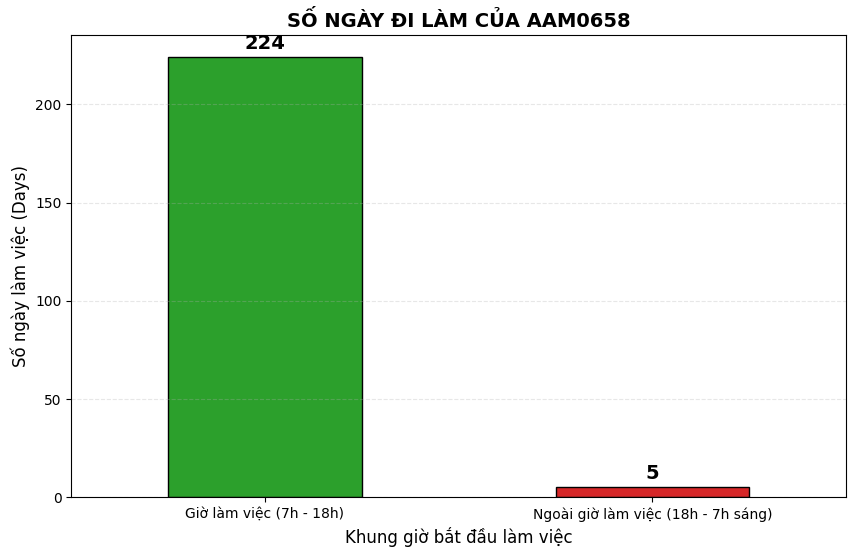


📊 KẾT QUẢ THỐNG KÊ:
Shift_Type
Giờ làm việc (7h - 18h)               224
Ngoài giờ làm việc (18h - 7h sáng)      5
Name: Date_Only, dtype: int64


In [4]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# ================= 1. CẤU HÌNH =================
DATA_DIR = "/kaggle/input/cert-r4-2/archive" 
TARGET_USER = 'AAM0658' # User kỹ thuật viên truy cập Wikileaks

print(f"🚀 ĐANG PHÂN TÍCH TẦN SUẤT NGÀY LÀM VIỆC CỦA {TARGET_USER}...")

# ================= 2. XỬ LÝ DỮ LIỆU =================
logon_path = os.path.join(DATA_DIR, 'logon.csv')

if os.path.exists(logon_path):
    # List chứa dữ liệu
    data_list = []
    
    # Đọc file (Chunking để đỡ tốn RAM)
    for chunk in pd.read_csv(logon_path, chunksize=1000000):
        chunk = chunk[chunk['user'] == TARGET_USER]
        # Chỉ lấy hành động Logon (Bắt đầu phiên làm việc)
        chunk = chunk[chunk['activity'] == 'Logon']
        
        if not chunk.empty:
            data_list.append(chunk[['date']])
            
    if data_list:
        df = pd.concat(data_list)
        df['ts'] = pd.to_datetime(df['date'], format='%m/%d/%Y %H:%M:%S')
        
        # Tạo cột Ngày (để đếm số ngày)
        df['Date_Only'] = df['ts'].dt.strftime('%Y-%m-%d')
        # Tạo cột Giờ (để phân loại)
        df['Hour'] = df['ts'].dt.hour
        
        # --- LOGIC PHÂN LOẠI ---
        # Hành chính: 6h sáng đến 8h tối (cho phép OT nhẹ)
        # Ban đêm: 20h tối đến 5h sáng hôm sau
        def classify_shift(h):
            if 7 <= h <= 18:
                return 'Giờ làm việc (7h - 18h)'
            else:
                return 'Ngoài giờ làm việc (18h - 7h sáng)'
                
        df['Shift_Type'] = df['Hour'].apply(classify_shift)
        
        # Đếm số ngày duy nhất cho mỗi loại
        # (Một ngày có thể logon nhiều lần, nhưng chỉ tính là 1 ngày làm việc)
        daily_stats = df.groupby('Shift_Type')['Date_Only'].nunique()
        
        # Đảm bảo có đủ 2 cột dù dữ liệu thiếu
        if 'Giờ làm việc (7h - 18h)' not in daily_stats: daily_stats['Giờ làm việc (7h - 18h)'] = 0
        if 'Ngoài giờ làm việc (18h - 7h sáng)' not in daily_stats: daily_stats['Ngoài giờ làm việc (18h - 7h sáng)'] = 0
        
        # Sắp xếp lại cho đẹp
        daily_stats = daily_stats[['Giờ làm việc (7h - 18h)', 'Ngoài giờ làm việc (18h - 7h sáng)']]

        # ================= 3. VẼ BIỂU ĐỒ =================
        plt.figure(figsize=(10, 6))
        
        # Màu sắc: Xanh (Tốt) vs Đỏ (Xấu)
        colors = ['#2ca02c', '#d62728'] 
        
        ax = daily_stats.plot(kind='bar', color=colors, edgecolor='black', rot=0)
        
        plt.title(f"SỐ NGÀY ĐI LÀM CỦA {TARGET_USER}", fontsize=14, fontweight='bold')
        plt.ylabel("Số ngày làm việc (Days)", fontsize=12)
        plt.xlabel("Khung giờ bắt đầu làm việc", fontsize=12)
        plt.grid(axis='y', linestyle='--', alpha=0.3)
        
        # Hiển thị con số cụ thể trên đầu cột
        for p in ax.patches:
            ax.annotate(str(p.get_height()), 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='center', 
                        xytext=(0, 10), 
                        textcoords='offset points',
                        fontsize=14, fontweight='bold')

        # Lưu ảnh
        # chart_filename = f"Chart_Days_Analysis_{TARGET_USER}.png"
        #plt.savefig(chart_filename)
        plt.show()
        
        print("\n📊 KẾT QUẢ THỐNG KÊ:")
        print(daily_stats)
        #print(f"\n✅ Đã lưu biểu đồ: {chart_filename}")
        
    else:
        print("Không tìm thấy dữ liệu user.")

🚀 ĐANG PHÂN TÍCH TOÀN BỘ HOẠT ĐỘNG (ACTIVE HOURS) CỦA AAM0658...
   -> Đang quét mẫu hoạt động toàn công ty...
   -> Đang quét hoạt động của AAM0658...


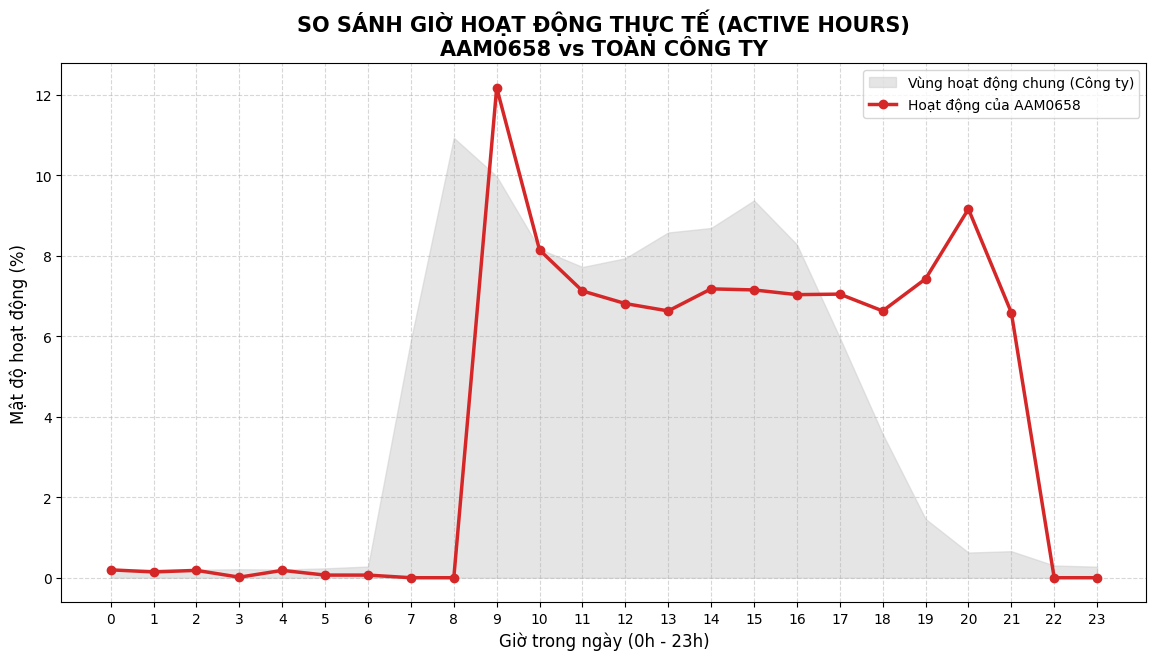


✅ Đã xong! Biểu đồ này sẽ cho thấy công ty làm việc trải dài từ 7h-18h.


In [6]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# ================= CẤU HÌNH =================
DATA_DIR = "/kaggle/input/cert-r4-2/archive" 
TARGET_USER = 'AAM0658'

print(f"🚀 ĐANG PHÂN TÍCH TOÀN BỘ HOẠT ĐỘNG (ACTIVE HOURS) CỦA {TARGET_USER}...")

# ================= HÀM ĐỌC DỮ LIỆU TỔNG HỢP =================
def load_all_activities(user_id=None):
    all_hours = []
    
    # Danh sách các file log cần quét
    log_files = ['logon.csv', 'email.csv', 'http.csv', 'device.csv', 'file.csv']
    
    for fname in log_files:
        fpath = os.path.join(DATA_DIR, fname)
        if not os.path.exists(fpath): continue
        
        # Đọc từng file
        # Nếu user_id=None -> Lấy mẫu toàn công ty (chỉ đọc 500k dòng mỗi file cho nhanh)
        # Nếu user_id có giá trị -> Lấy hết dữ liệu của user đó
        chunksize = 1000000
        nrows = 500000 if user_id is None else None
        
        for chunk in pd.read_csv(fpath, chunksize=chunksize, nrows=nrows):
            # Nếu lọc theo user
            if user_id:
                chunk = chunk[chunk['user'] == user_id]
            
            if not chunk.empty:
                # Convert Date
                try:
                    ts = pd.to_datetime(chunk['date'], format='%m/%d/%Y %H:%M:%S')
                    all_hours.extend(ts.dt.hour.tolist())
                except: pass
                
    return all_hours

# ================= THỰC THI =================

# 1. Lấy mẫu giờ hoạt động của TOÀN CÔNG TY (Baseline)
print("   -> Đang quét mẫu hoạt động toàn công ty...")
company_hours = load_all_activities(user_id=None)

# 2. Lấy giờ hoạt động của TARGET USER
print(f"   -> Đang quét hoạt động của {TARGET_USER}...")
user_hours = load_all_activities(user_id=TARGET_USER)

if company_hours and user_hours:
    # Chuyển đổi sang DataFrame để vẽ
    df_company = pd.DataFrame(company_hours, columns=['Hour'])
    df_user = pd.DataFrame(user_hours, columns=['Hour'])
    
    # Tính phần trăm
    company_pct = df_company['Hour'].value_counts(normalize=True).sort_index() * 100
    user_pct = df_user['Hour'].value_counts(normalize=True).sort_index() * 100
    
    # Đảm bảo đủ 24h trên trục hoành
    for h in range(24):
        if h not in company_pct: company_pct[h] = 0
        if h not in user_pct: user_pct[h] = 0
    
    company_pct = company_pct.sort_index()
    user_pct = user_pct.sort_index()

    # ================= VẼ BIỂU ĐỒ =================
    plt.figure(figsize=(14, 7))
    
    # Vẽ miền giờ làm việc chung (Area Chart)
    plt.fill_between(company_pct.index, company_pct.values, color='#CCCCCC', alpha=0.5, label='Vùng hoạt động chung (Công ty)')
    
    # Vẽ đường của User
    plt.plot(user_pct.index, user_pct.values, color='#D62728', linewidth=2.5, marker='o', label=f'Hoạt động của {TARGET_USER}')
    
    # Trang trí
    plt.title(f"SO SÁNH GIỜ HOẠT ĐỘNG THỰC TẾ (ACTIVE HOURS)\n{TARGET_USER} vs TOÀN CÔNG TY", fontsize=15, fontweight='bold')
    plt.xlabel("Giờ trong ngày (0h - 23h)", fontsize=12)
    plt.ylabel("Mật độ hoạt động (%)", fontsize=12)
    plt.xticks(range(0, 24))
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    
    # Highlight vùng 1h sáng
    #plt.axvline(x=1, color='red', linestyle='--', alpha=0.5)
    #plt.text(1.2, user_pct.max()/2, 'BẤT THƯỜNG\n(1:34 AM)', color='red', fontweight='bold')

    #plt.savefig(f"Chart_ActiveHours_{TARGET_USER}.png")
    plt.show()
    
    print("\n✅ Đã xong! Biểu đồ này sẽ cho thấy công ty làm việc trải dài từ 7h-18h.")
else:
    print("❌ Không đủ dữ liệu để vẽ.")

In [1]:
import pandas as pd
import numpy as np
import os
import glob
import warnings

warnings.filterwarnings('ignore')

# ================= 1. CẤU HÌNH MỤC TIÊU =================
DATA_DIR = "/kaggle/input/cert-r4-2/archive" 
ANSWERS_DIR = "/kaggle/input/cert42-answer/answers/"
LDAP_DIR = os.path.join(DATA_DIR, "LDAP")

# 🎯 CHỐT CỨNG ĐỐI TƯỢNG ĐỂ LẤY BẰNG CHỨNG NGOẠI PHẠM
TARGET_USER = 'FAW0032' 
TARGET_DATE = '2010-08-13'

print(f"🚀 BẮT ĐẦU: TẠO BẰNG CHỨNG NGOẠI PHẠM CHO {TARGET_USER} NGÀY {TARGET_DATE}...")

# ================= 2. LOAD DANH SÁCH ĐỘC HẠI (ĐỂ TÔ ĐỎ KẺ MẠO DANH) =================
# Chúng ta cần load đáp án của kịch bản 3 (BBS0039) vì FAW0032 là nạn nhân trong đó
def get_malicious_ids():
    malicious_ids = set()
    try:
        # Tìm file đáp án của BBS0039 (Kẻ tấn công FAW0032)
        # Đường dẫn thường là r4.2-3-BBS0039.csv
        search_pattern = os.path.join(ANSWERS_DIR, "**", "*BBS0039*.csv")
        files = glob.glob(search_pattern, recursive=True)
        
        for fpath in files:
            with open(fpath, 'r') as f:
                for line in f:
                    parts = line.strip().split(',')
                    if len(parts) > 1:
                        # Lưu ID độc hại
                        malicious_ids.add(parts[1])
                        malicious_ids.add(parts[1].replace('{','').replace('}',''))
    except Exception as e: print(f"⚠️ Không load được file đáp án: {e}")
    return malicious_ids

MALICIOUS_IDS = get_malicious_ids()
print(f"   -> Đã nạp {len(MALICIOUS_IDS)} hành vi độc hại để đối chiếu.")

# ================= 3. HÀM XUẤT EXCEL (TÔ MÀU XANH/ĐỎ) =================
def save_alibi_excel(df, filename):
    print(f"📄 Xuất báo cáo: {filename}")
    try:
        import xlsxwriter
        writer = pd.ExcelWriter(filename, engine='xlsxwriter')
        df.to_excel(writer, sheet_name='Alibi_Report', index=False)
        workbook  = writer.book
        worksheet = writer.sheets['Alibi_Report']
        
        # Format Header
        header_fmt = workbook.add_format({'bold': True, 'border': 1, 'align': 'left', 'bg_color': '#D9D9D9'})
        for col_num, value in enumerate(df.columns.values):
            worksheet.write(0, col_num, value, header_fmt)
            
        # Format XANH (Chính chủ) - ĐỎ (Mạo danh)
        green_fmt = workbook.add_format({'font_color': '#006100', 'bg_color': '#C6EFCE'}) # Xanh lá
        red_fmt = workbook.add_format({'font_color': '#9C0006', 'bg_color': '#FFC7CE', 'bold': True}) # Đỏ đậm
        
        # Áp dụng format
        col_label = df.columns.get_loc('Label')
        worksheet.conditional_format(1, 0, df.shape[0], df.shape[1]-1, {'type': 'formula', 'criteria': f'=$F2="Benign"', 'format': green_fmt})
        worksheet.conditional_format(1, 0, df.shape[0], df.shape[1]-1, {'type': 'formula', 'criteria': f'=$F2="MALICIOUS"', 'format': red_fmt})
        
        # Chỉnh độ rộng
        worksheet.set_column(0, 0, 20) # Time
        worksheet.set_column(6, 6, 50) # Detail
        
        writer.close()
    except: df.to_excel(filename, index=False)

# ================= 4. XỬ LÝ LOG CHÍNH =================
print(f"[2/3] Đang quét toàn bộ hành vi của {TARGET_USER}...")

all_logs = []
log_files = ['logon.csv', 'device.csv', 'file.csv', 'http.csv', 'email.csv']

for fname in log_files:
    fpath = os.path.join(DATA_DIR, fname)
    if not os.path.exists(fpath): continue
    
    for chunk in pd.read_csv(fpath, chunksize=500000):
        # 1. Lọc đúng User FAW0032
        chunk = chunk[chunk['user'] == TARGET_USER].copy()
        if chunk.empty: continue
        
        # 2. Lọc đúng ngày 2010-08-13
        chunk['ts'] = pd.to_datetime(chunk['date'], format='%m/%d/%Y %H:%M:%S')
        chunk['date_str'] = chunk['ts'].dt.strftime('%Y-%m-%d')
        chunk = chunk[chunk['date_str'] == TARGET_DATE].copy()
        if chunk.empty: continue
        
        chunk['id_str'] = chunk['id'].astype(str)
        
        # 3. Gán nhãn: Có trong list độc hại -> MALICIOUS, không thì -> Benign
        chunk['Label'] = chunk['id_str'].apply(lambda x: 'MALICIOUS' if x in MALICIOUS_IDS else 'Benign')
        
        chunk['Type'] = fname.replace('.csv', '').capitalize()
        chunk['Role'] = "Manager" # FAW0032 là sếp
        
        # 4. Chi tiết hóa
        if fname == 'logon.csv':
            chunk['Activity'] = chunk['activity']
            # Quan trọng: Hiển thị Logoff rõ ràng
            chunk['Detail'] = chunk.apply(lambda x: f"Action: {x['activity']} on {x['pc']}", axis=1)
        
        elif fname == 'email.csv':
            chunk['Activity'] = "Send"
            chunk['Detail'] = "To: " + chunk['to'].astype(str).str[:50]
            if 'content' in chunk.columns: # Thêm content nếu có
                 chunk['Detail'] += " | Content: " + chunk['content'].astype(str).str[:50]
                 
        elif fname == 'http.csv':
            chunk['Activity'] = "Visit"
            chunk['Detail'] = chunk['url']
            
        elif fname == 'device.csv':
            chunk['Activity'] = chunk['activity']
            chunk['Detail'] = chunk['pc']
            
        elif fname == 'file.csv':
            chunk['Activity'] = "Open"
            chunk['Detail'] = chunk['filename']

        all_logs.append(chunk[['ts', 'user', 'Role', 'Type', 'Activity', 'Label', 'Detail']])

# ================= 5. TỔNG HỢP =================
if all_logs:
    df_final = pd.concat(all_logs, ignore_index=True)
    df_final.sort_values('ts', inplace=True)
    
    # Format lại thời gian
    df_final.rename(columns={'ts': 'Time', 'user': 'User'}, inplace=True)
    df_final['Time'] = df_final['Time'].dt.strftime('%Y-%m-%d %H:%M:%S')
    
    # Xuất file
    filename = f"Alibi_Evidence_{TARGET_USER}_{TARGET_DATE}.xlsx"
    save_alibi_excel(df_final, filename)
    print(f"\n✅ HOÀN TẤT! Đã tạo bằng chứng ngoại phạm: {filename}")
else:
    print("❌ Không tìm thấy dữ liệu nào khớp yêu cầu.")

🚀 BẮT ĐẦU: TẠO BẰNG CHỨNG NGOẠI PHẠM CHO FAW0032 NGÀY 2010-08-13...
   -> Đã nạp 38 hành vi độc hại để đối chiếu.
[2/3] Đang quét toàn bộ hành vi của FAW0032...
📄 Xuất báo cáo: Alibi_Evidence_FAW0032_2010-08-13.xlsx

✅ HOÀN TẤT! Đã tạo bằng chứng ngoại phạm: Alibi_Evidence_FAW0032_2010-08-13.xlsx
